**Handling Class Imbalance in Anomaly Detection with SMOTE and Logistic Regression**

This code creates an imbalanced dataset to simulate anomaly detection, where anomalies are rare. It trains two logistic regression models: one on the original data and another using SMOTE to balance the classes. It compares their performance using accuracy, recall, F1 score, and ROC AUC, and shows the results with confusion matrices and class distribution plots. The goal is to show how balancing the data with SMOTE can improve detection of rare events.

Dataset size BEFORE SMOTE (Train): (7000, 15)
Class distribution BEFORE SMOTE: Counter({0: 6827, 1: 173})


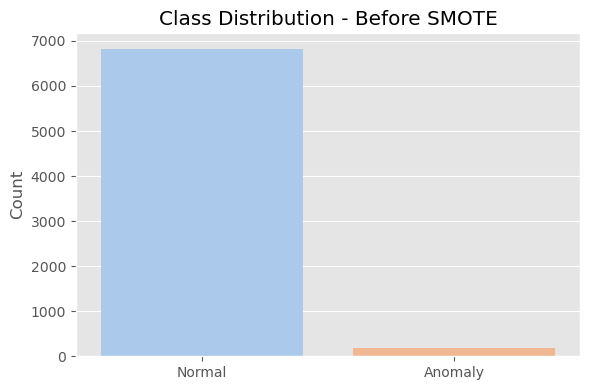

Dataset size AFTER SMOTE: (13654, 15)
Class distribution AFTER SMOTE: Counter({0: 6827, 1: 6827})


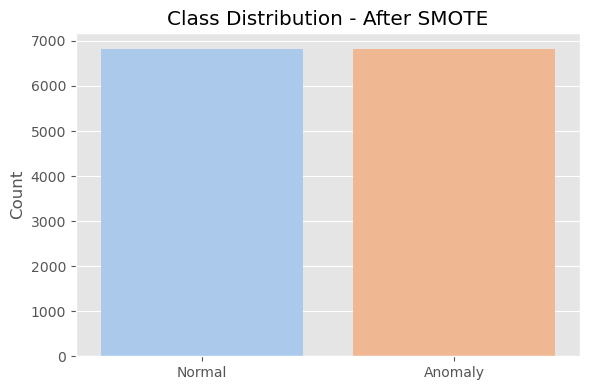

Training completed.

                 MODEL COMPARISON                 

Results for Without SMOTE:
Accuracy:  0.9760
Recall:    0.0270
F1 Score:  0.0526
ROC AUC:   0.7189


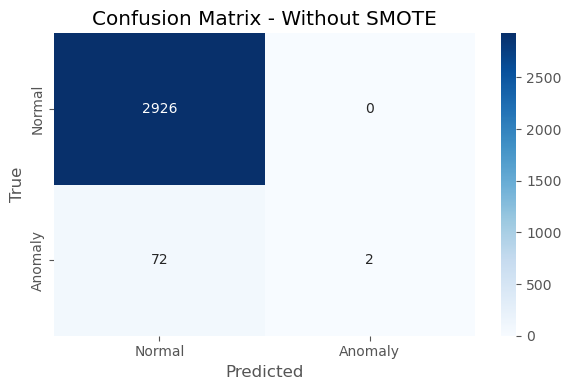


Results for With SMOTE:
Accuracy:  0.7137
Recall:    0.6622
F1 Score:  0.1024
ROC AUC:   0.7397


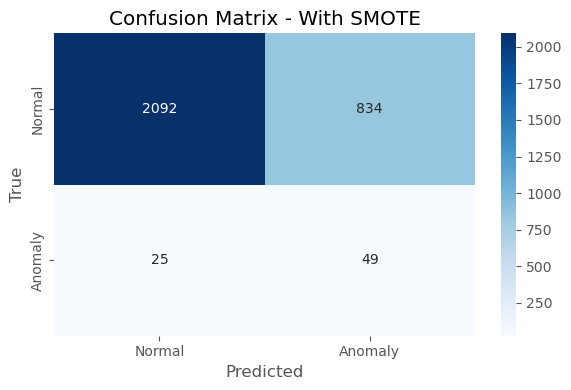


Performance comparison:
Metric        Before (Baseline)      After (SMOTE)
--------------------------------------------------
Accuracy                 0.9760             0.7137
Recall                   0.0270             0.6622
F1 Score                 0.0526             0.1024
ROC AUC                  0.7189             0.7397


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')


class AnomalyDetector:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.smote = SMOTE(random_state=random_state)
        self.model = Pipeline([
            ('smote', self.smote),
            ('classifier', LogisticRegression(random_state=random_state))
        ])
        self.baseline_model = LogisticRegression(random_state=random_state)
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.X_train_res, self.y_train_res = None, None

    def generate_data(self, n_samples=10000, weights=[0.98, 0.02]):
        X, y = make_classification(
            n_samples=n_samples,
            n_features=15,
            n_informative=8,
            n_redundant=3,
            weights=weights,
            flip_y=0.01,
            random_state=self.random_state
        )
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=self.random_state
        )

        print(f"Dataset size BEFORE SMOTE (Train): {self.X_train.shape}")
        print(f"Class distribution BEFORE SMOTE: {Counter(self.y_train)}")
        self.plot_class_distribution(self.y_train, "Before SMOTE")

        self.X_train_res, self.y_train_res = self.smote.fit_resample(self.X_train, self.y_train)

        print(f"Dataset size AFTER SMOTE: {self.X_train_res.shape}")
        print(f"Class distribution AFTER SMOTE: {Counter(self.y_train_res)}")
        self.plot_class_distribution(self.y_train_res, "After SMOTE")

    def plot_class_distribution(self, y_data, title=""):
        counter = Counter(y_data)
        labels, values = zip(*counter.items())
        labels = ['Normal', 'Anomaly'] if set(labels) == {0, 1} else labels
        plt.figure(figsize=(6, 4))
        sns.barplot(x=labels, y=values, palette='pastel')
        plt.title(f"Class Distribution - {title}")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    def train_models(self):
        self.baseline_model.fit(self.X_train, self.y_train)
        self.model.fit(self.X_train, self.y_train)
        print("Training completed.")

    def evaluate_model(self, model, X, y, model_name=""):
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else [0]*len(X)

        metrics = {
            'Accuracy': accuracy_score(y, y_pred),
            'Recall': recall_score(y, y_pred),
            'F1 Score': f1_score(y, y_pred),
            'ROC AUC': roc_auc_score(y, y_prob),
        }

        print(f"\nResults for {model_name}:")
        for name, value in metrics.items():
            print(f"{name + ':':<10} {value:.4f}")

        self.plot_confusion_matrix(y, y_pred, model_name)

        return metrics

    def plot_confusion_matrix(self, y_true, y_pred, title=""):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Normal', 'Anomaly'],
                    yticklabels=['Normal', 'Anomaly'])
        plt.title(f'Confusion Matrix - {title}')
        plt.ylabel('True')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()

    def compare_models(self):
        print("\n" + "="*50)
        print("MODEL COMPARISON".center(50))
        print("="*50)

        baseline_metrics = self.evaluate_model(
            self.baseline_model, self.X_test, self.y_test, "Without SMOTE"
        )
        smote_metrics = self.evaluate_model(
            self.model, self.X_test, self.y_test, "With SMOTE"
        )

        print("\nPerformance comparison:")
        print(f"{'Metric':<12} {'Before (Baseline)':>18} {'After (SMOTE)':>18}")
        print("-"*50)
        for metric in baseline_metrics:
            print(f"{metric:<12} {baseline_metrics[metric]:>18.4f} {smote_metrics[metric]:>18.4f}")

    def run(self):
        self.generate_data()
        self.train_models()
        self.compare_models()


if __name__ == "__main__":
    detector = AnomalyDetector(random_state=42)
    detector.run()

Interpretation : 
Before applying SMOTE, the model had high accuracy (97.60%) but performed very poorly in detecting anomalies, with a recall of only 2.7%. This means it failed to identify most of the rare cases. After using SMOTE to balance the dataset, the model's accuracy dropped (71.37%)—which is expected since the class distribution changed—but the ability to detect anomalies significantly improved, with recall increasing to 66.22%. The F1 score and ROC AUC also improved. This shows that SMOTE helped the model better detect anomalies.

Question :  Explain why Accuracy is a bad metric here and why Precision-Recall or F1 are better.
Accuracy is often a poor metric for evaluating models on imbalanced datasets because it simply measures the overall proportion of correct predictions without considering the distribution of classes. When one class dominates, a model can achieve high accuracy by mostly predicting the majority class, while failing to correctly identify the minority class. This makes accuracy misleading in such contexts. Metrics like precision, recall, and F1 score provide a more meaningful assessment by focusing specifically on the model’s ability to correctly identify and differentiate the minority class. They balance the trade-offs between false positives and false negatives, offering a clearer picture of performance where detecting the less frequent but important class is critical.